## Using ilastik for 3d segmentation

In this notebook, we show how to use [Ilastik](https://www.ilastik.org/) for 3d image segmentation. Obtaining a 3d segmentation of your sample of interest is the first step in the tissue cartography pipeline. The surface to be extracted from the 3d microscopy data is then defined as the segmentation boundary, i.e. between "inside" and "outside". This should become a lot clearer by working through a concrete example - the mildly curved surface of an epithelium from a confocal $z$-stack (data from (Lye et al. 2024)[https://doi.org/10.1371/journal.pbio.3002611].

There are many tools available for segmenting 3d data, and you can use whichever one you would like. The only thing that matters is that it provides you a 3d mask that defines which part of the image is "inside" and which part is "outside", and that can be loaded into python to create a mesh. There are also other methods to create a mesh which do not require a segmentation but only a list of points on your surface (see tutorial XXX), or you can provide the mesh directly.

However, in our experience  Ilastik is the most extremely robust and versatile tool for getting segmentations and meshes, and we use it in almost all of our tissue cartography pipelines. This is why we recommend it as a starting point.

Ilastik uses machine learning algorithms to segment and classify your data. You draw the labels on your data, and the algorithm predicts a segmentation. You correct the errors interactively until you are happy. No machine learning expertise required.

Ilastik works great because it makes a "custom" model for your dataset. This means you don't need to worry about whether your data is similar or not to the training data of some segmentation algorithm, or fiddle with parameters. Once trained, you can reuse Ilastik models for batch prediction.

We start by loading the require python modules.

In [1]:
# these are the modules with the tissue cartography code
from blender_tissue_cartography import io as tcio # for file reading and saving
from blender_tissue_cartography import mesh as tcmesh # for mesh handling
import mcubes # for creating a surface mesh

In [2]:
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt

## Load and subsample data for segmentation

**Data description** myosin + membrane ventral view of Drosophila embryo during germband extension, from Lye et al. 2024.

Let's load the dataset. We then enter the relevant metadata - the filename, resolution in microns, and how much we want to subsample for segmentation purposes.

In [3]:
# start by entering the filename   
metadata_dict = {'filename': 'ilastik_example/basics_example'}

In [4]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape)

image shape: (2, 26, 454, 511)


#### Resolution info and subsampling

From the image shape, we can see that the spatial axes are in $z-x-y$ order. We use this information to correctly enter the resolution in microns/pixel for each axis.
You can typically get this info from the `.tif` metadata. We then subsample the image for rapid segmentation. This will greatly speed up the segmentation process. It is usually a good idea to make the subsampled  image approximately isotropic. Subsample so much that the geometry of your object of interest is still visible (i.e. curvature and/or wrinkles in your surface).

In [5]:
metadata_dict['resolution_in_microns'] = (1, 0.36, 0.36)
metadata_dict['subsampling_factors'] = (1, 1/3, 1/3)

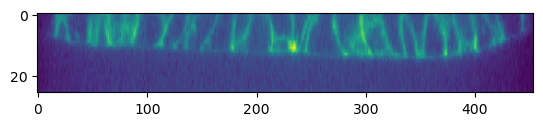

In [6]:
# let's plot the data in a cross section

plt.imshow(image[1,:,:,250],
           aspect=metadata_dict['resolution_in_microns'][0]/metadata_dict['resolution_in_microns'][1])

In [7]:
subsampled_image = transform.rescale(image, metadata_dict['subsampling_factors'],
                                     channel_axis=0, preserve_range=True)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (2, 26, 151, 170)


We now save the subsampled image a `.h5` file for input into ilastik for segmentation. `.h5` files are faster to read for ilastik and perform much better than `.tif`'s.

In [8]:
tcio.write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

## Create 3d segmentation

We now use [ilastik binary pixel classification](https://www.ilastik.org/documentation/pixelclassification/pixelclassification). 

Start Ilastik, and select binary pixel classification:

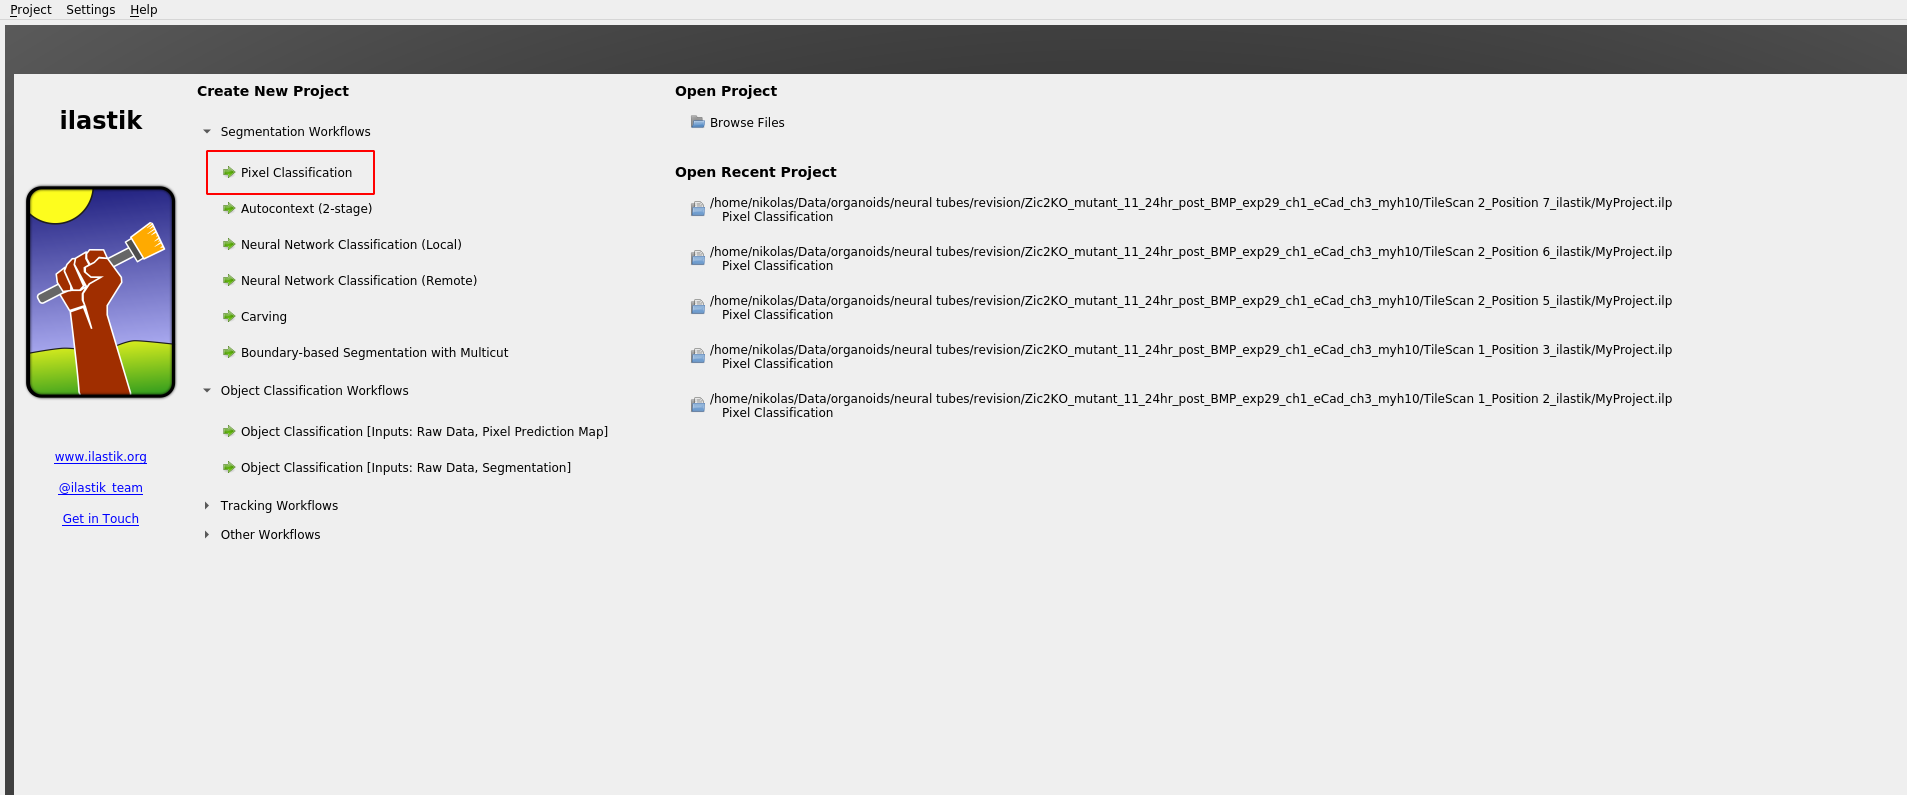

Save the project `.ilp` file to the `ilastik_example` directory.

Now let's add the dataset:

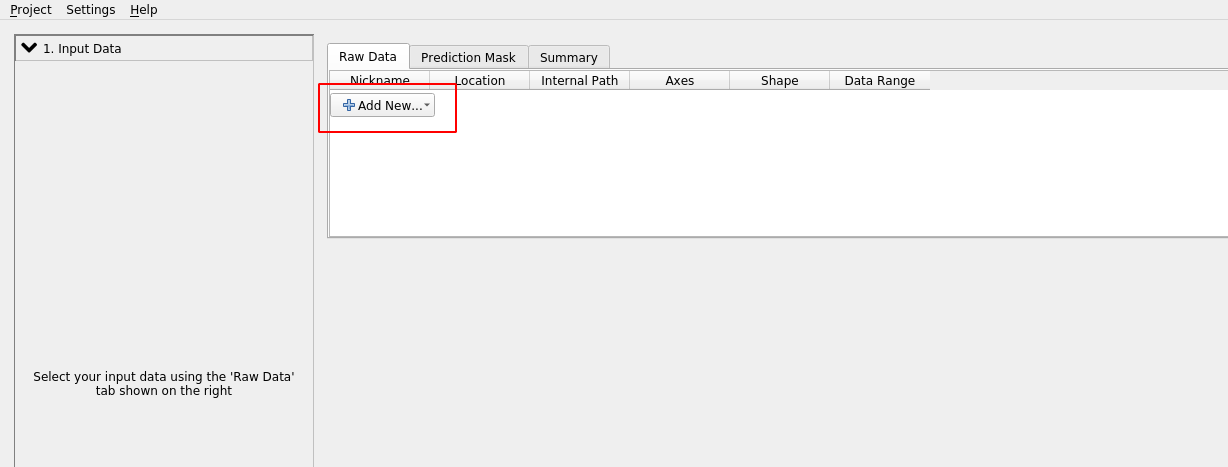

Click "add separate images" and select `basics_example_subsampled.h5` from the `ilastik_example` directory.

### Attention: Axis order

Ilastik does not alway know what the axes in your input data mean. For example, it might think the "channel" axis is the "z" axis. Let's fix this by "right click" on the dataset and "edit properties":

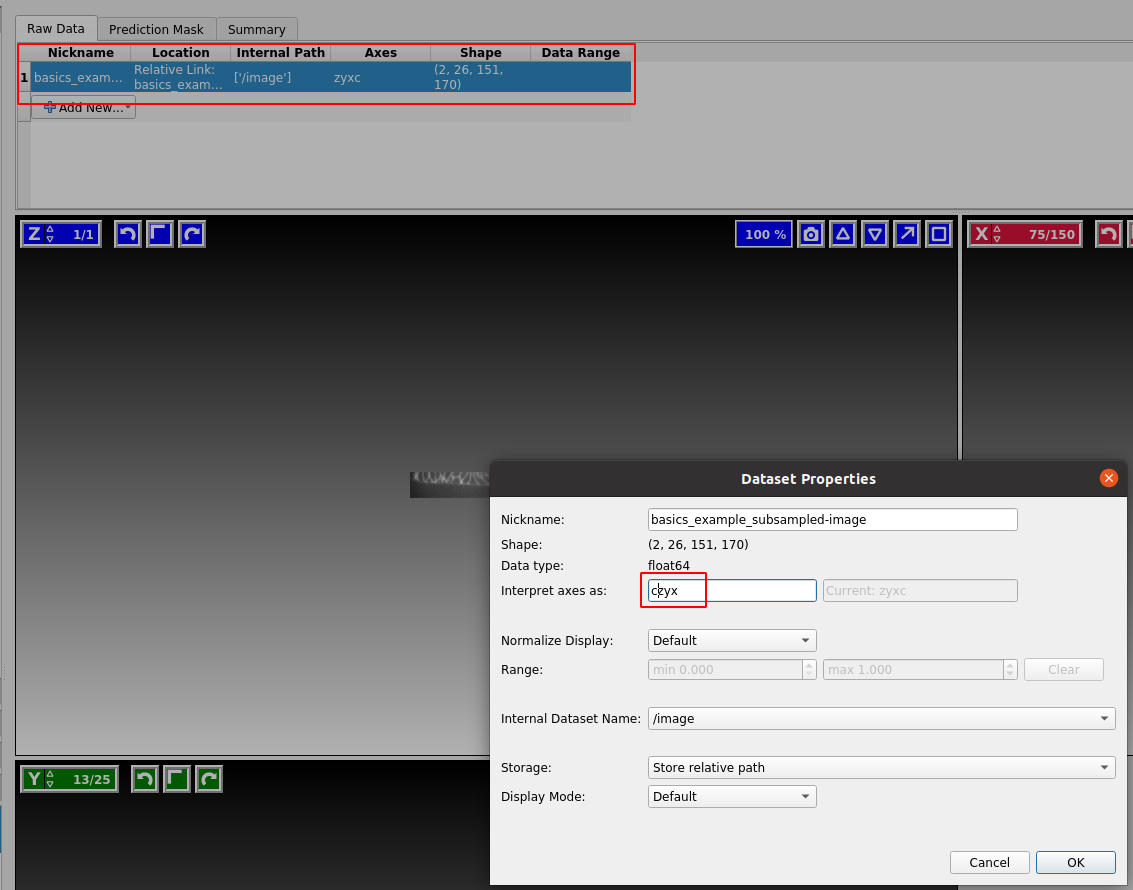

Our dataset is in `czyx` order. By convention, `blender_tissue_cartography` always puts the channel as the first axis. Ilastik should show you three cross-sections of your data in red/green color. Click on "Feature selection" on the left toolbar to continue.

### Feature selection

Ilastik internally works by applying a bunch of different image filters (like smoothing, or edge detection) to your data, and using the results as input for a machine learning model. You now select which filters ("Features") you want. In general, it is save to just select everything. If you get an error, it may be the case that the size of the filter is bigger than the smallest axis (e.g. the $z$-axis) in your image. In this case, click the top bar to make the filter "2d":

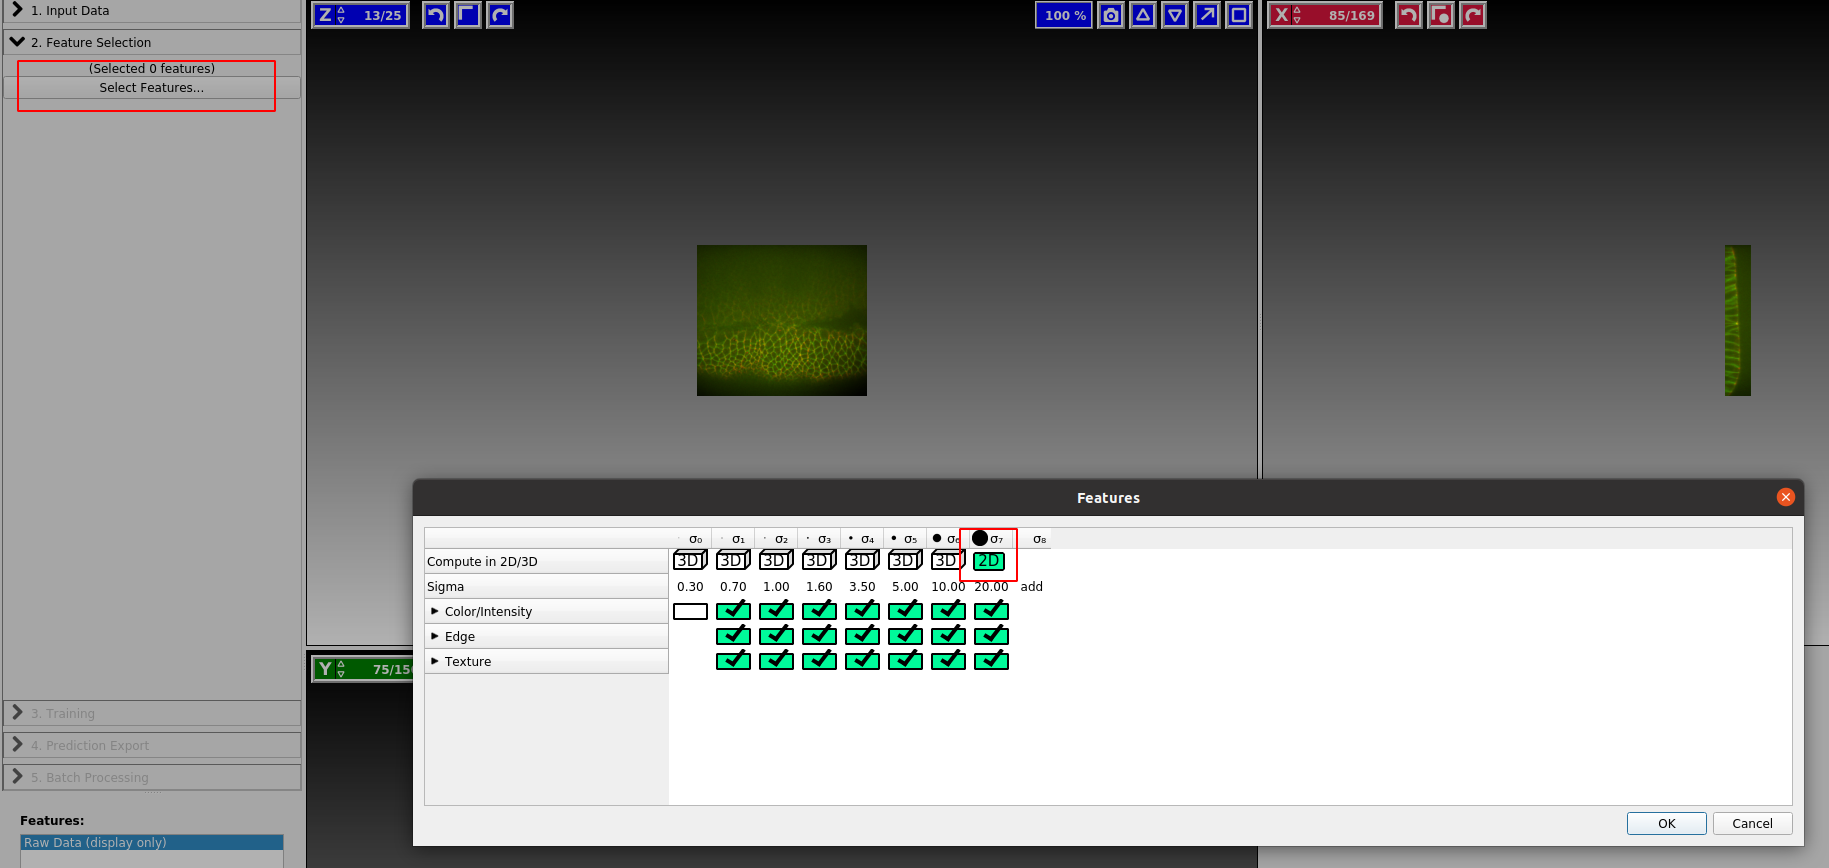


### Training

We now continue to "Training". Zoom in to one of the cross sections, and paint the "inside" of the sample in yellow, and the "outside" in blue. You can also add more labels, but here we will just need two. You just need to make a few brush strokes and ilastik will start making predictions. Click the "Live Update" button:

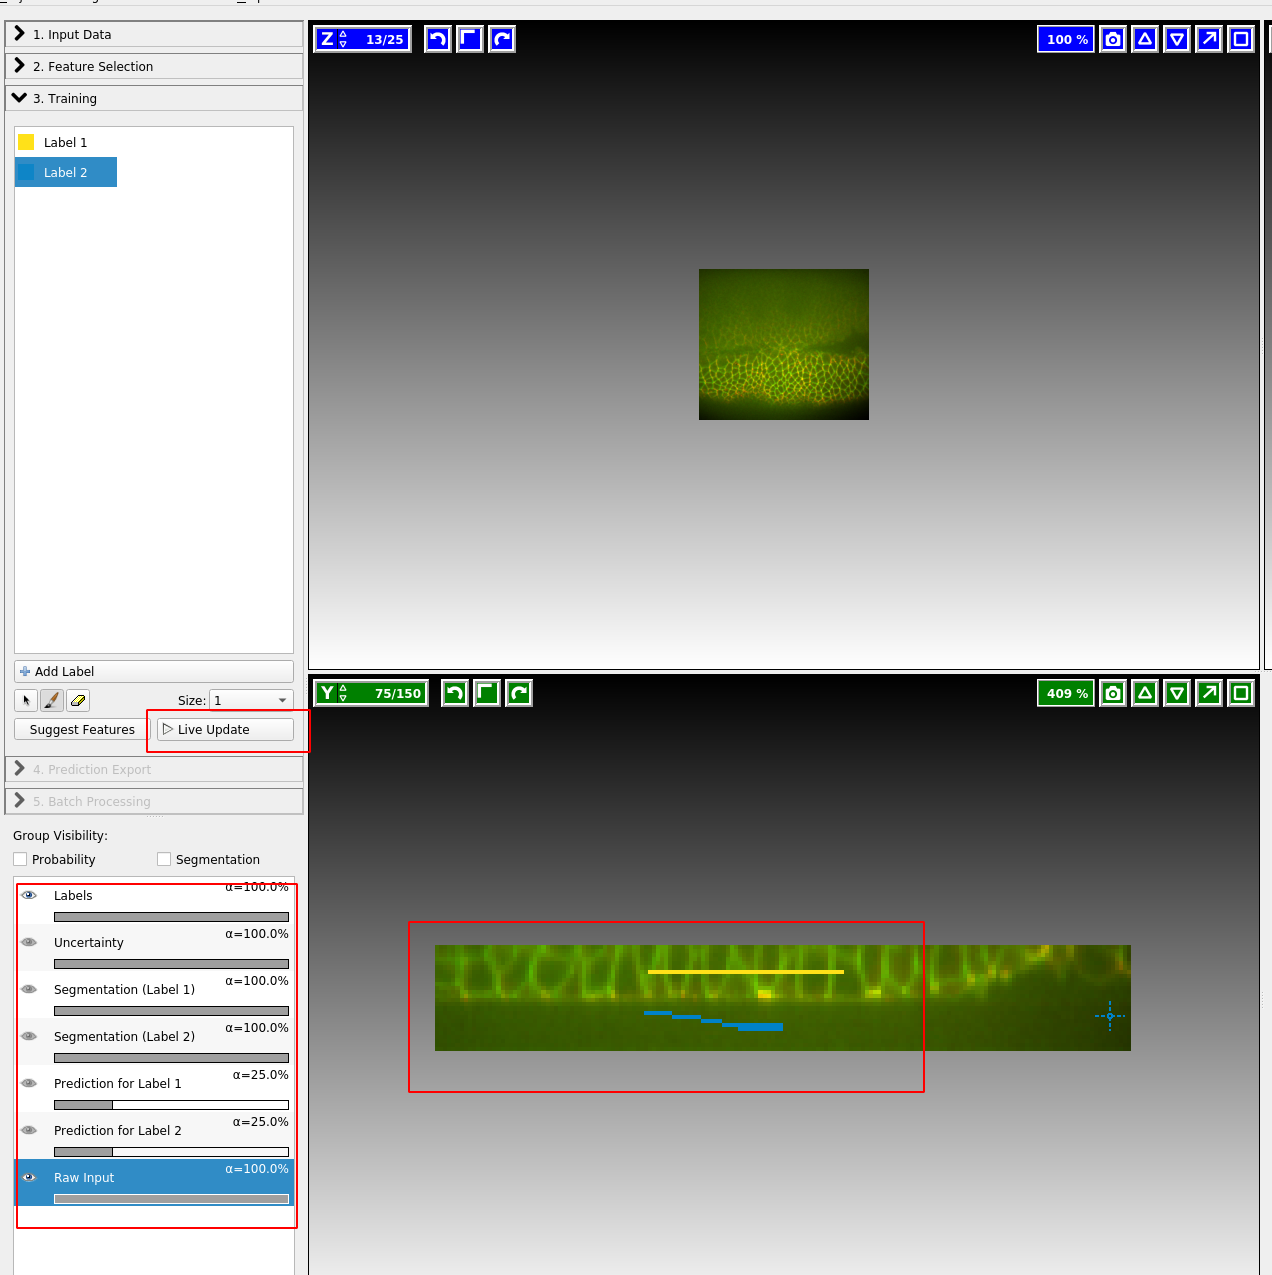

On the left, you can adjust the lookup table for your data, and decide what features of the prediction you want to see. I find it very helpful to look at "Uncertainty" which shows you in light blue you about where the algorithm is still unsure:

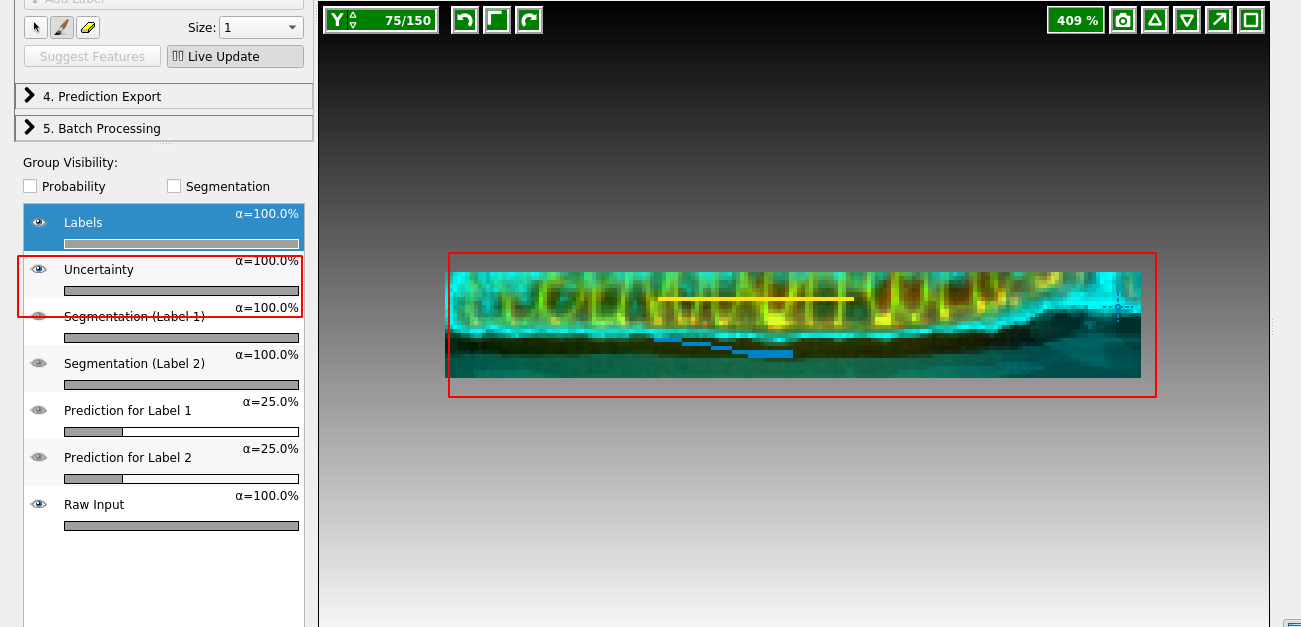

Now paint more labels until you are happy with the classification. Target the regions of high uncertainty, and look in all three cross sections. It is important that the classification boundary tightly matches the surface you want to extract!

### Prediction Export

Once you are happy with the results, let's go to "Prediction Export" on the left toolbar. Use "Source: Probabilities" and click "export all":

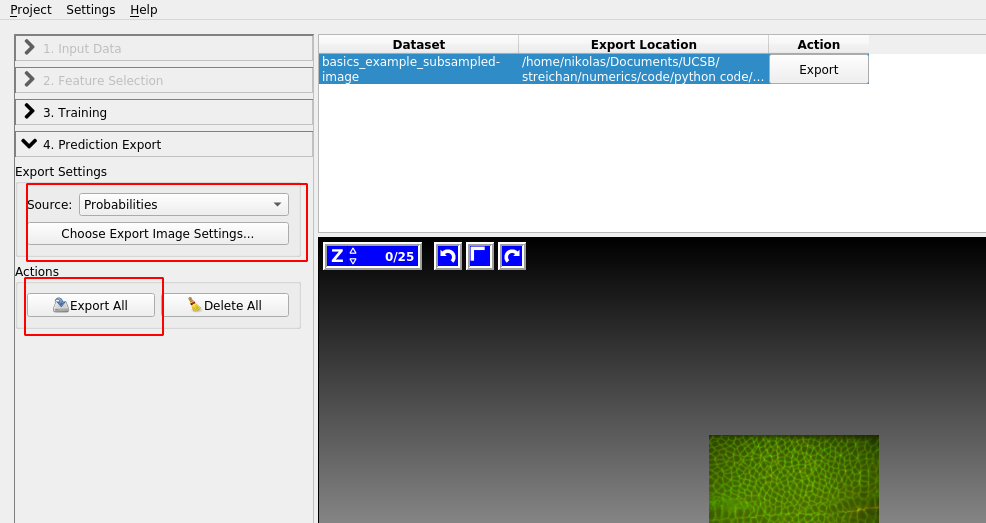

You can adjust the axis order and output format under "Choose Export Image Settings" if you need.

### Batch processing

You can apply the Ilastik model to multiple datasets, using the "Batch Processing" tab on the left toolbar. In general, I recommend doing this only for datasets that are highly "comparable", e.g. recorded with exactly the same microscopy settings. Since it's fairly easy and quick to train a new ilastik model for each dataset, trying to build a model that will work across all your recordings is often not worth it.


**Attention: data normalization**

If you plan on reusing the same model, it is recommended to normalize your data, so that the pixel values are always of the same approximate magnitude. Do this _before_ you save the data as `.h5`'s, for example using the provided `normalize_quantiles_zstack`-function:

In [9]:
tcio.write_h5(f"{metadata_dict['filename']}_subsampled_normalized.h5",
              tcio.normalize_quantiles_zstack(subsampled_image))

### Loading segmentation into jupyter

After creating an ilastik project, training the model, and exporting the probabilities, we load the exported probabilities back into python.

The resulting segmentations has two channels for the probability of a pixel being "inside" and "outside".

In [10]:
segmentation = tcio.read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (26, 151, 170)


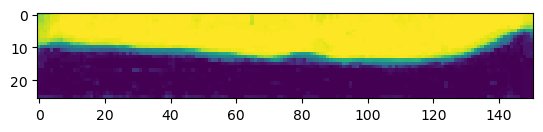

In [11]:
# look at the segmentation in a cross section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

### Computational post-processing

In our simple example, the segmentation story ends here, since the ilastik output already provides a great segmentation of our data. But we are not always so lucky, and sometimes extra processing is necessary.

I can recommend the [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html) module (for fixing holes, removing small erroneous "blobs" in your segmentation, etc.), and the [morphsnakes](https://github.com/pmneila/morphsnakes) package which works by computationally "inflating a balloon" at a seed point, with the ilastik probability output acting as a barrier. See this example, with the "balloon" in blue:
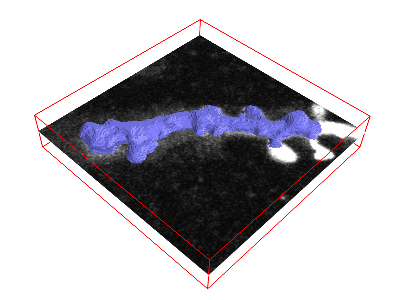
This is very helpful when your ilastik output defines the _boundary_ of the object you want to segment, not its volume. The morphsnakes package is explained in tutorial 6.

Don't worry if your segmentation contains some small errors. We can fix the resulting errors in the surface in blender's graphical user interface in the next step.

## Meshing

We can convert the segmentation into a triangular mesh using the marching cubes method, and save the mesh. We save all meshes in as wavefront `.obj` files (see [wikipedia](https://en.wikipedia.org/wiki/Wavefront_.obj_file)).

**Important convention** For sanities sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

We then save the mesh to disk. In the next tutorial, we will load this mesh in the 3d software [blender](https://www.blender.org/) which is the heart of the tissue cartography pipeline

In [12]:
# now we create a 3d mesh of using the marching cubes method

vertices, faces = tcmesh.marching_cubes(segmentation, isovalue=0.5, sigma_smoothing=3)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

mesh = tcmesh.ObjMesh(vertices_in_microns, faces)
mesh.name = "basics_example_mesh_marching_cubes"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")